In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import numpy as np

C:\Users\cichy\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "cuda"

In [3]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.ToTensor(),
    target_transform=transforms.Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.ToTensor(),
    target_transform=transforms.Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

In [4]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [5]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    
class ConvolutionalNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1,32,kernel_size=3),
            nn.MaxPool2d(2,stride=1),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32,32,kernel_size=3),
            nn.MaxPool2d(2,stride=1),
            nn.ReLU()
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(32,64,kernel_size=3),
            nn.MaxPool2d(2,stride=2),
            nn.ReLU()
        )
        self.fc1 = nn.Sequential(
            nn.Linear(6400, 256),
            nn.ReLU()
        )
        self.fc2 = nn.Sequential(
            nn.Linear(256, 10),
            nn.Softmax()
        )
        

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(-1, 6400)
        x = self.fc1(x)
        logits = self.fc2(x)
        return logits

In [6]:
def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    losses = []
    for batch, (X, y) in enumerate(dataloader):
        pred = model(X.cuda())
        loss = loss_fn(pred, y.cuda())

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            losses.append(loss.item())
    return losses


def test_loop(dataloader, model, loss_fn):
    model.eval()
    test_loss, correct = 0, 0
    losses, accuracy = [], []
    
    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            pred = model(X.cuda())
            test_loss = loss_fn(pred, y.cuda()).item()
            correct += (pred.argmax(1) == y.argmax(1).cuda()).type(torch.float).sum().item()
            
            if batch % 50 == 49:
                losses.append(test_loss)
                accuracy.append(correct/(pred.shape[0]*100))
                correct = 0
                
                

    return losses, accuracy

In [7]:
def experiment(model, optimizer, loss_fn):
    

    epochs = 100
    train_losses, test_losses, test_accuracy = [], [], []
    for t in range(epochs):
        train_loss = train_loop(train_dataloader, model, loss_fn, optimizer)
        train_losses.append(np.mean(train_loss))
        test_loss, test_acc = test_loop(test_dataloader, model, loss_fn)
        test_losses.append(np.mean(test_loss))
        [test_accuracy.append(x)for x in test_acc]
    return train_losses, test_losses, test_accuracy

In [8]:
def plot_results(train_losses, test_losses, test_accuracy, name):
    fig, axs = plt.subplots(1,2, figsize=(11,5))
    axs[0].plot(train_losses, label= "train")
    axs[0].plot(test_losses, label="test")
    axs[0].legend()
    axs[0].set_xlabel("epoch")
    axs[0].set_ylabel("loss")
    axs[0].set_title("Test and training loss")

    axs[1].plot(test_accuracy)
    axs[1].set_xlabel("50 batches")
    axs[1].set_ylabel("accuracy")
    axs[1].set_title("Test accuracy")
    plt.suptitle(name)
    plt.show()

C:\Users\cichy\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


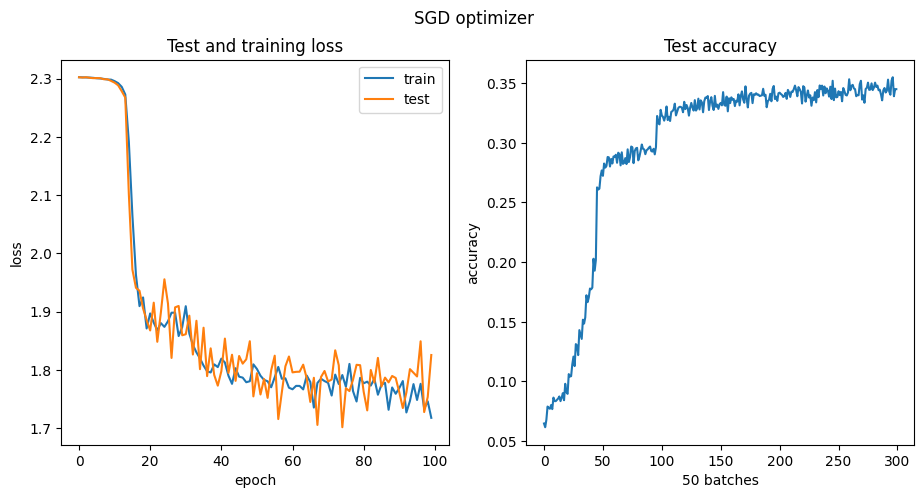

In [9]:
model = ConvolutionalNeuralNetwork().to(device)
train_losses, test_losses, test_accuracy = experiment(model, torch.optim.SGD(model.parameters(), lr=1e-3), nn.CrossEntropyLoss().to(device))
plot_results(train_losses, test_losses, test_accuracy, "SGD optimizer")

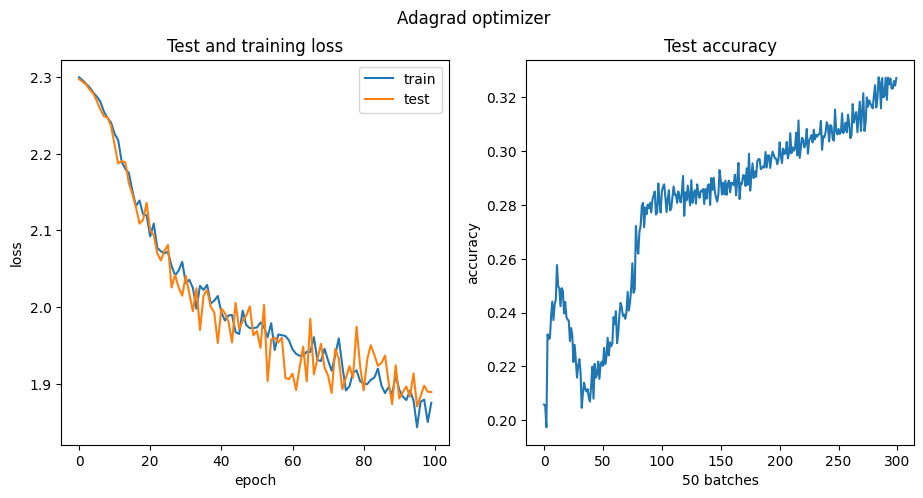

In [10]:
model = ConvolutionalNeuralNetwork().to(device)
train_losses, test_losses, test_accuracy = experiment(model, torch.optim.Adagrad(model.parameters(), lr=1e-5), nn.CrossEntropyLoss().to(device))
plot_results(train_losses, test_losses, test_accuracy, "Adagrad optimizer")

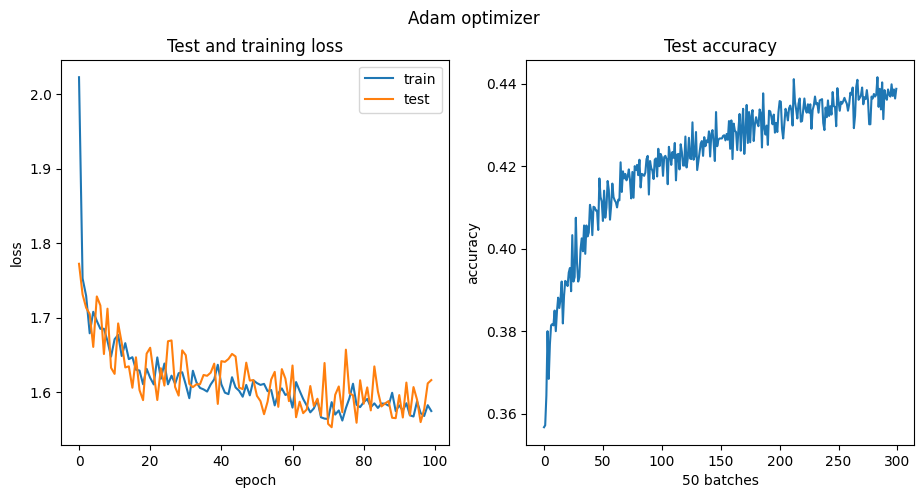

In [11]:
model = ConvolutionalNeuralNetwork().to(device)
train_losses, test_losses, test_accuracy = experiment(model, torch.optim.Adam(model.parameters(), lr=1e-5), nn.CrossEntropyLoss().to(device))
plot_results(train_losses, test_losses, test_accuracy, "Adam optimizer")